# Modeling Hot Water Energy

### Select the parameters for the experiment and log in the experiment folder

In [1]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 5  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hw_st',
             'hx_vlv1']  # input predictors
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = True  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe', 'hw_sf']  # create sum aggregate for these columns
rolling_mean_target = [
    'hw_st', 'hw_rt', 'oat', 'sat', 'orh', 'ghi', 'avg_stpt','hx_vlv1'
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

#threshold: lower bound below which we ignore the row data(needed for removing hybrid system)
threshold = 2

# Custom way to create Training Data
data_weeks = 52  # Create a large initial block 6 months ~ 26 weeks of training and testing data
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 16,
    'lstm_no_layers': 1,
    'dense_hidden_units': 16,
    'dense_no_layers': 4,
    'retrain_from_layers': 0,
    'stateful': False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = False  # freeze weights of certain layers
reinitialize = False  # reinitialize the weights of certain layers
model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

### Set Seed in numpy, Keras and TF for reproducability
### Import modules
### Set GPU configurations

In [2]:
import shutil
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'data_weeks' : data_weeks,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

### Read the cleaned data

In [6]:
# read the pickled file for ahu data
dfdata = dp.readfile(datapath)

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

# show data
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1
2018-07-13 07:50:00,80.913567,79.320808,82.0,0.0,32.546185,562.0,69.52381,39.534317,0.0,94.427994,89.589584,0.276543
2018-07-13 07:55:00,80.913567,79.023285,82.0,0.0,29.293947,580.0,69.52381,39.809956,0.0,94.125771,89.589584,0.276543
2018-07-13 08:00:00,80.615402,79.023285,82.0,0.0,30.685425,597.0,69.52381,39.174774,0.0,94.125771,89.589584,0.276543
2018-07-13 08:05:00,80.303123,79.023285,82.0,0.0,30.074446,614.0,69.52381,35.745533,0.0,93.816162,89.229790,0.276543
2018-07-13 08:10:00,80.303123,79.023285,79.0,0.0,29.646845,625.0,69.52381,34.858036,0.0,93.816162,89.229790,0.276543


### Smooth the data

In [7]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

### Adjust lag for certain columns if needed

In [8]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

### Create aggregate data: aggregate specified columns at specified intervals

In [9]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

### Create temporal chunks of data

In [10]:
df = df[df>=threshold]

In [11]:
df.describe()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1
count,21971.000000,21971.000000,21971.000000,15531.000000,19760.000000,12413.000000,21971.000000,20022.000000,16139.000000,21971.000000,21971.000000,18062.000000
mean,63.626614,70.279134,60.052722,29.165470,25.506893,306.759824,71.543837,40.969165,71.491092,101.209748,91.814132,30.573137
std,17.450034,5.512664,17.310180,25.215924,16.265920,273.355487,1.049029,29.263558,54.022207,14.162833,13.195301,17.495896
min,17.821972,51.710091,17.309428,2.000835,2.000535,2.000742,66.053821,2.000614,2.000303,80.126469,64.979626,2.000211
25%,49.121291,67.371189,46.642814,10.626127,9.415199,63.651555,70.895248,12.208731,30.061699,90.171847,82.486249,12.012631
50%,65.803442,71.937603,59.389471,18.280464,26.324579,222.561712,71.342867,39.425200,56.690203,93.372415,87.652451,30.596166
75%,77.806630,73.668137,74.189350,45.395671,39.563011,517.294489,72.485714,65.365650,90.149782,112.294702,98.313362,46.635110
max,97.319737,90.031056,95.007589,160.411511,66.524093,966.352894,73.558137,125.398265,195.213976,147.491708,135.359499,73.435671


In [12]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 76


In [ ]:
dp.dataframeplot(df.iloc[0:1000,:],lazy=False,style='b*',legend=True)

### Custom way to create Training Data

In [11]:
# Since we are training across time, we need to ensure the input and output time steps are now 1
# otherwise the rearrangment of the data for batch speedup will be violated
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

#### Create placeholder and functions

In [13]:
from pandas import concat, Timedelta


def quickmerge(listdf):
    return concat(listdf)


def df_list_reshape(datablock_df):
    new_df_list = []
    for i in range(int(10080 / (5 * period))):
        new_df_list.append(
            datablock_df[(datablock_df.index - datablock_df.index[i]) %
                         Timedelta('7 days') == '0 days 00:00:00'])
    return new_df_list

weeklist = []  # create list of training, testing arrays

#### Initial Data Block for offline training

In [14]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[0:data_weeks-1]
datablock_train = quickmerge(datablock_train_pre)
#divide into non-zero operating region
datablock_train = dp.subsequencing(datablock_train, period=period)
#drop smaller blocks
datablock_train = [item for item in datablock_train if item.shape[0] >= 2*modelconfig['train_batchsize']]
#merge them together
minibatch_train = quickmerge(datablock_train)

# select weeks=1 worth of data
datablock_test_pre = dflist[data_weeks-1]
#divide into non-zero operating region
datablock_test = dp.subsequencing(datablock_test_pre, period=period)
#drop smaller blocks
datablock_test = [item for item in datablock_test if item.shape[0] >= 2*modelconfig['test_batchsize']]
#merge them together
minibatch_test = quickmerge(datablock_test)


# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index


# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[0].year), 
                                      str(minibatch_test.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

#### Create small blocks of data for weekly training

In [15]:
for weekdata in dflist[data_weeks:]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[datablock_test_pre]
    datablock_train = quickmerge(datablock_train_pre)
    #divide into non-zero operating region
    datablock_train = dp.subsequencing(datablock_train, period=period)
    #drop smaller blocks
    datablock_train = [item for item in datablock_train if item.shape[0] >= 2*modelconfig['train_batchsize']]
    #merge them together
    minibatch_train = quickmerge(datablock_train)
    
    # select weeks=1 worth of data
    datablock_test_pre = weekdata
    #divide into non-zero operating region
    datablock_test = dp.subsequencing(datablock_test_pre, period=period)
    #drop smaller blocks
    datablock_test = [item for item in datablock_test if item.shape[0] >= 2*modelconfig['test_batchsize']]
    #merge them together
    minibatch_test = quickmerge(datablock_test)
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(minibatch_test.index[-1].year), 
                                      str(minibatch_test.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 25


#### Print size and shape of data to feed to the LSTM for sanity checks

In [16]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-28
name: X_train, shape: (3500, 1, 7)
name: y_train, shape: (3500, 1, 1)
name: X_test, shape: (335, 1, 7)
name: y_test, shape: (335, 1, 1)
name: test_idx, shape: (335,)
name: Id, shape: Year-2019-Week-30
name: X_train, shape: (3657, 1, 7)
name: y_train, shape: (3657, 1, 1)
name: X_test, shape: (333, 1, 7)
name: y_test, shape: (333, 1, 1)
name: test_idx, shape: (333,)
name: Id, shape: Year-2019-Week-31
name: X_train, shape: (3658, 1, 7)
name: y_train, shape: (3658, 1, 1)
name: X_test, shape: (332, 1, 7)
name: y_test, shape: (332, 1, 1)
name: test_idx, shape: (332,)
name: Id, shape: Year-2019-Week-32
name: X_train, shape: (3711, 1, 7)
name: y_train, shape: (3711, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx, shape: (336,)
name: Id, shape: Year-2019-Week-33
name: X_train, shape: (3794, 1, 7)
name: y_train, shape: (3794, 1, 1)
name: X_test, shape: (150, 1, 7)
name: y_test, shape: (150, 1, 1)
name: test_idx, shape: (1

#### Add weekly train test data to modelconfig dictionary for ease of training

In [17]:
modelconfig['weeklist'] = weeklist

###  Clear the Tensorflow graph from previous training

In [18]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# nn_model.model.summary()

### Perform relearning on chunks of temporal data

In [19]:
for weekno, BatchData in enumerate(tqdm(modelconfig['weeklist'])):

    """Begin weekly training"""   
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']

    try:
        del nn_model
    except NameError:
        pass

    K.clear_session()

    #Instantiate learner model
    nn_model = mp.simple_LSTM_model(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile()   

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']
   
    try:
        del nn_model_pred
    except NameError:
        pass
    K.clear_session()

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.simple_LSTM_model(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=outputcols)

    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    saveloc=path,
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/25 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
 - 1s - loss: 0.0147
Epoch 2/5000
 - 1s - loss: 0.0150
Epoch 3/5000
 - 0s - loss: 0.0164
Epoch 4/5000
 - 1s - loss: 0.0164
Epoch 5/5000
 - 1s - loss: 0.0150
Epoch 6/5000
 - 1s - loss: 0.0142
Epoch 7/5000
 - 1s - loss: 0.0134
Epoch 8/5000
 - 1s - loss: 0.0126
Epoch 9/5000
 - 1s - loss: 0.0117
Epoch 10/5000
 - 1s - loss: 0.0107
Epoch 11/5000
 - 1s - loss: 0.0096
Epoch 12/5000
 - 1s - loss: 0.0081
Epoch 13/5000
 - 1s - loss: 0.0062
Epoch 14/5000
 - 1s - loss: 0.0049
Epoch 15/5000
 - 1s - loss: 0.0041
Epoch 16/5000
 - 1s - loss: 0.0035
Epoch 17/5000
 - 1s - loss: 0.0032
Epoch 18/5000
 - 1s - loss: 0.0029
Epoch 19/5000
 - 1s - loss: 0.0028
Epoch 20/5000
 - 1s - loss: 0.0026
Epoch 21/5000
 - 1s - loss: 0.0025
Epoch 22/5000
 - 1s - loss: 0.0024
Epoch 23/5000
 - 1s - loss: 0.0024
Epoch 24/5000
 - 1s - loss: 0.0023
Epoch 25/5000
 - 1s - loss: 0.0023
Epoch 26/5000
 - 1s - loss: 0.0023


  4%|▍         | 1/25 [00:37<14:59, 37.50s/it]

Epoch 61/5000
 - 1s - loss: 0.0028
Epoch 62/5000
 - 1s - loss: 0.0025
Epoch 63/5000
 - 1s - loss: 0.0025
Epoch 64/5000
 - 1s - loss: 0.0025
Epoch 65/5000
 - 1s - loss: 0.0025
Epoch 66/5000
 - 1s - loss: 0.0022
Epoch 67/5000
 - 1s - loss: 0.0021
Epoch 68/5000
 - 1s - loss: 0.0021
Epoch 69/5000
 - 1s - loss: 0.0020
Epoch 70/5000
 - 1s - loss: 0.0020
Epoch 71/5000
 - 1s - loss: 0.0020
Epoch 72/5000
 - 1s - loss: 0.0019
Epoch 73/5000
 - 1s - loss: 0.0019
Epoch 74/5000
 - 1s - loss: 0.0019
Epoch 75/5000
 - 1s - loss: 0.0019
Epoch 76/5000
 - 1s - loss: 0.0019
Epoch 77/5000
 - 1s - loss: 0.0019
Epoch 78/5000
 - 1s - loss: 0.0019
Epoch 79/5000
 - 1s - loss: 0.0019
Epoch 80/5000
 - 1s - loss: 0.0019
Epoch 81/5000
 - 1s - loss: 0.0019
Epoch 82/5000
 - 1s - loss: 0.0019
Epoch 83/5000
 - 1s - loss: 0.0019
Epoch 84/5000
 - 1s - loss: 0.0019
Epoch 85/5000
 - 1s - loss: 0.0019
Epoch 86/5000
 - 1s - loss: 0.0019
Epoch 87/5000
 - 1s - loss: 0.0019
Epoch 88/5000
 - 1s - loss: 0.0019
Epoch 89/5000
 - 1s 

  8%|▊         | 2/25 [01:02<12:54, 33.68s/it]

Epoch 98/5000
 - 1s - loss: 0.0025
Epoch 99/5000
 - 1s - loss: 0.0024
Epoch 100/5000
 - 1s - loss: 0.0023
Epoch 101/5000
 - 1s - loss: 0.0023
Epoch 102/5000
 - 1s - loss: 0.0023
Epoch 103/5000
 - 1s - loss: 0.0021
Epoch 104/5000
 - 1s - loss: 0.0020
Epoch 105/5000
 - 1s - loss: 0.0019
Epoch 106/5000
 - 1s - loss: 0.0019
Epoch 107/5000
 - 1s - loss: 0.0019
Epoch 108/5000
 - 1s - loss: 0.0018
Epoch 109/5000
 - 1s - loss: 0.0018
Epoch 110/5000
 - 1s - loss: 0.0018
Epoch 111/5000
 - 1s - loss: 0.0018
Epoch 112/5000
 - 1s - loss: 0.0018
Epoch 113/5000
 - 1s - loss: 0.0018
Epoch 114/5000
 - 1s - loss: 0.0018
Epoch 115/5000
 - 1s - loss: 0.0018
Epoch 116/5000
 - 1s - loss: 0.0018
Epoch 117/5000
 - 1s - loss: 0.0018
Epoch 118/5000
 - 1s - loss: 0.0018
Epoch 119/5000
 - 1s - loss: 0.0018
Epoch 120/5000
 - 1s - loss: 0.0018
Epoch 121/5000
 - 1s - loss: 0.0018
Epoch 122/5000
 - 1s - loss: 0.0018
Epoch 123/5000
 - 1s - loss: 0.0018
Epoch 124/5000
 - 1s - loss: 0.0018
Epoch 125/5000
 - 1s - loss: 0

 12%|█▏        | 3/25 [01:26<11:21, 30.97s/it]

Epoch 135/5000
 - 1s - loss: 0.0021
Epoch 136/5000
 - 1s - loss: 0.0023
Epoch 137/5000
 - 1s - loss: 0.0022
Epoch 138/5000
 - 1s - loss: 0.0023
Epoch 139/5000
 - 1s - loss: 0.0020
Epoch 140/5000
 - 1s - loss: 0.0019
Epoch 141/5000
 - 1s - loss: 0.0018
Epoch 142/5000
 - 1s - loss: 0.0018
Epoch 143/5000
 - 1s - loss: 0.0018
Epoch 144/5000
 - 1s - loss: 0.0017
Epoch 145/5000
 - 1s - loss: 0.0017
Epoch 146/5000
 - 1s - loss: 0.0017
Epoch 147/5000
 - 1s - loss: 0.0017
Epoch 148/5000
 - 1s - loss: 0.0017
Epoch 149/5000
 - 1s - loss: 0.0017
Epoch 150/5000
 - 1s - loss: 0.0017
Epoch 151/5000
 - 1s - loss: 0.0017
Epoch 152/5000
 - 1s - loss: 0.0017
Epoch 153/5000
 - 1s - loss: 0.0017
Epoch 154/5000
 - 1s - loss: 0.0017
Epoch 155/5000
 - 1s - loss: 0.0017
Epoch 156/5000
 - 1s - loss: 0.0017
Epoch 157/5000
 - 1s - loss: 0.0017
Epoch 158/5000
 - 1s - loss: 0.0017
Epoch 159/5000
 - 1s - loss: 0.0017
Epoch 160/5000
 - 1s - loss: 0.0017
Epoch 161/5000
 - 1s - loss: 0.0017
Epoch 162/5000
 - 1s - loss:

 16%|█▌        | 4/25 [01:53<10:24, 29.76s/it]

Epoch 175/5000
 - 1s - loss: 0.0020
Epoch 176/5000
 - 1s - loss: 0.0021
Epoch 177/5000
 - 1s - loss: 0.0021
Epoch 178/5000
 - 1s - loss: 0.0021
Epoch 179/5000
 - 1s - loss: 0.0019
Epoch 180/5000
 - 1s - loss: 0.0018
Epoch 181/5000
 - 1s - loss: 0.0017
Epoch 182/5000
 - 1s - loss: 0.0017
Epoch 183/5000
 - 1s - loss: 0.0016
Epoch 184/5000
 - 1s - loss: 0.0016
Epoch 185/5000
 - 1s - loss: 0.0016
Epoch 186/5000
 - 1s - loss: 0.0016
Epoch 187/5000
 - 1s - loss: 0.0016
Epoch 188/5000
 - 1s - loss: 0.0016
Epoch 189/5000
 - 1s - loss: 0.0016
Epoch 190/5000
 - 1s - loss: 0.0016
Epoch 191/5000
 - 1s - loss: 0.0016
Epoch 192/5000
 - 1s - loss: 0.0016
Epoch 193/5000
 - 1s - loss: 0.0016
Epoch 194/5000
 - 1s - loss: 0.0016
Epoch 195/5000
 - 1s - loss: 0.0016
Epoch 196/5000
 - 1s - loss: 0.0016
Epoch 197/5000
 - 1s - loss: 0.0016
Epoch 198/5000
 - 1s - loss: 0.0016
Epoch 199/5000
 - 1s - loss: 0.0016
Epoch 200/5000
 - 1s - loss: 0.0016
Epoch 201/5000
 - 1s - loss: 0.0016
Epoch 202/5000
 - 1s - loss:

 20%|██        | 5/25 [02:18<09:24, 28.23s/it]

Epoch 211/5000
 - 1s - loss: 0.0020
Epoch 212/5000
 - 1s - loss: 0.0021
Epoch 213/5000
 - 1s - loss: 0.0021
Epoch 214/5000
 - 1s - loss: 0.0020
Epoch 215/5000
 - 1s - loss: 0.0018
Epoch 216/5000
 - 1s - loss: 0.0017
Epoch 217/5000
 - 1s - loss: 0.0017
Epoch 218/5000
 - 1s - loss: 0.0016
Epoch 219/5000
 - 1s - loss: 0.0016
Epoch 220/5000
 - 1s - loss: 0.0016
Epoch 221/5000
 - 1s - loss: 0.0016
Epoch 222/5000
 - 1s - loss: 0.0016
Epoch 223/5000
 - 1s - loss: 0.0015
Epoch 224/5000
 - 1s - loss: 0.0015
Epoch 225/5000
 - 1s - loss: 0.0015
Epoch 226/5000
 - 1s - loss: 0.0015
Epoch 227/5000
 - 1s - loss: 0.0015
Epoch 228/5000
 - 1s - loss: 0.0015
Epoch 229/5000
 - 1s - loss: 0.0015
Epoch 230/5000
 - 1s - loss: 0.0015
Epoch 231/5000
 - 1s - loss: 0.0015
Epoch 232/5000
 - 1s - loss: 0.0015
Epoch 233/5000
 - 1s - loss: 0.0015
Epoch 234/5000
 - 1s - loss: 0.0015
Epoch 235/5000
 - 1s - loss: 0.0015
Epoch 236/5000
 - 1s - loss: 0.0015
Epoch 237/5000
 - 1s - loss: 0.0015
Epoch 238/5000
 - 1s - loss:

 24%|██▍       | 6/25 [02:39<08:16, 26.14s/it]

Epoch 242/5000
 - 1s - loss: 0.0019
Epoch 243/5000
 - 1s - loss: 0.0020
Epoch 244/5000
 - 1s - loss: 0.0020
Epoch 245/5000
 - 1s - loss: 0.0020
Epoch 246/5000
 - 1s - loss: 0.0018
Epoch 247/5000
 - 1s - loss: 0.0017
Epoch 248/5000
 - 1s - loss: 0.0016
Epoch 249/5000
 - 1s - loss: 0.0016
Epoch 250/5000
 - 1s - loss: 0.0015
Epoch 251/5000
 - 1s - loss: 0.0015
Epoch 252/5000
 - 1s - loss: 0.0015
Epoch 253/5000
 - 1s - loss: 0.0015
Epoch 254/5000
 - 1s - loss: 0.0015
Epoch 255/5000
 - 1s - loss: 0.0015
Epoch 256/5000
 - 1s - loss: 0.0015
Epoch 257/5000
 - 1s - loss: 0.0015
Epoch 258/5000
 - 1s - loss: 0.0015
Epoch 259/5000
 - 1s - loss: 0.0015
Epoch 260/5000
 - 1s - loss: 0.0015
Epoch 261/5000
 - 1s - loss: 0.0015
Epoch 262/5000
 - 1s - loss: 0.0015
Epoch 263/5000
 - 1s - loss: 0.0015
Epoch 264/5000
 - 1s - loss: 0.0015
Epoch 265/5000
 - 1s - loss: 0.0015
Epoch 266/5000
 - 1s - loss: 0.0015
Epoch 267/5000
 - 1s - loss: 0.0015
Epoch 268/5000
 - 1s - loss: 0.0015
Epoch 269/5000
 - 1s - loss:

 28%|██▊       | 7/25 [03:06<07:52, 26.25s/it]

Epoch 281/5000
 - 1s - loss: 0.0020
Epoch 282/5000
 - 1s - loss: 0.0020
Epoch 283/5000
 - 1s - loss: 0.0020
Epoch 284/5000
 - 1s - loss: 0.0019
Epoch 285/5000
 - 1s - loss: 0.0017
Epoch 286/5000
 - 1s - loss: 0.0016
Epoch 287/5000
 - 1s - loss: 0.0016
Epoch 288/5000
 - 1s - loss: 0.0015
Epoch 289/5000
 - 1s - loss: 0.0015
Epoch 290/5000
 - 1s - loss: 0.0014
Epoch 291/5000
 - 1s - loss: 0.0014
Epoch 292/5000
 - 1s - loss: 0.0014
Epoch 293/5000
 - 1s - loss: 0.0014
Epoch 294/5000
 - 1s - loss: 0.0014
Epoch 295/5000
 - 1s - loss: 0.0014
Epoch 296/5000
 - 1s - loss: 0.0014
Epoch 297/5000
 - 1s - loss: 0.0014
Epoch 298/5000
 - 1s - loss: 0.0014
Epoch 299/5000
 - 1s - loss: 0.0014
Epoch 300/5000
 - 1s - loss: 0.0014
Epoch 301/5000
 - 1s - loss: 0.0014
Epoch 302/5000
 - 1s - loss: 0.0014
Epoch 303/5000
 - 1s - loss: 0.0014
Epoch 304/5000
 - 1s - loss: 0.0014
Epoch 305/5000
 - 1s - loss: 0.0014
Epoch 306/5000
 - 1s - loss: 0.0014
Epoch 307/5000
 - 1s - loss: 0.0014
Epoch 308/5000
 - 1s - loss:

 32%|███▏      | 8/25 [03:30<07:14, 25.55s/it]

Epoch 316/5000
 - 1s - loss: 0.0018
Epoch 317/5000
 - 1s - loss: 0.0020
Epoch 318/5000
 - 1s - loss: 0.0020
Epoch 319/5000
 - 1s - loss: 0.0020
Epoch 320/5000
 - 1s - loss: 0.0017
Epoch 321/5000
 - 1s - loss: 0.0016
Epoch 322/5000
 - 1s - loss: 0.0016
Epoch 323/5000
 - 1s - loss: 0.0015
Epoch 324/5000
 - 1s - loss: 0.0015
Epoch 325/5000
 - 1s - loss: 0.0015
Epoch 326/5000
 - 1s - loss: 0.0014
Epoch 327/5000
 - 1s - loss: 0.0014
Epoch 328/5000
 - 1s - loss: 0.0014
Epoch 329/5000
 - 1s - loss: 0.0014
Epoch 330/5000
 - 1s - loss: 0.0014
Epoch 331/5000
 - 1s - loss: 0.0014
Epoch 332/5000
 - 1s - loss: 0.0014
Epoch 333/5000
 - 1s - loss: 0.0014
Epoch 334/5000
 - 1s - loss: 0.0014
Epoch 335/5000
 - 1s - loss: 0.0014
Epoch 336/5000
 - 1s - loss: 0.0014
Epoch 337/5000
 - 1s - loss: 0.0014
Epoch 338/5000
 - 1s - loss: 0.0014
Epoch 339/5000
 - 1s - loss: 0.0014
Epoch 340/5000
 - 1s - loss: 0.0014
Epoch 341/5000
 - 1s - loss: 0.0014
Epoch 342/5000
 - 1s - loss: 0.0014
Epoch 343/5000
 - 1s - loss:

 36%|███▌      | 9/25 [03:55<06:45, 25.36s/it]

Epoch 352/5000
 - 1s - loss: 0.0017
Epoch 353/5000
 - 1s - loss: 0.0020
Epoch 354/5000
 - 1s - loss: 0.0019
Epoch 355/5000
 - 1s - loss: 0.0019
Epoch 356/5000
 - 1s - loss: 0.0016
Epoch 357/5000
 - 1s - loss: 0.0015
Epoch 358/5000
 - 1s - loss: 0.0015
Epoch 359/5000
 - 1s - loss: 0.0014
Epoch 360/5000
 - 1s - loss: 0.0014
Epoch 361/5000
 - 1s - loss: 0.0014
Epoch 362/5000
 - 1s - loss: 0.0014
Epoch 363/5000
 - 1s - loss: 0.0014
Epoch 364/5000
 - 1s - loss: 0.0014
Epoch 365/5000
 - 1s - loss: 0.0014
Epoch 366/5000
 - 1s - loss: 0.0014
Epoch 367/5000
 - 1s - loss: 0.0014
Epoch 368/5000
 - 1s - loss: 0.0014
Epoch 369/5000
 - 1s - loss: 0.0014
Epoch 370/5000
 - 1s - loss: 0.0014
Epoch 371/5000
 - 1s - loss: 0.0014
Epoch 372/5000
 - 1s - loss: 0.0014
Epoch 373/5000
 - 1s - loss: 0.0014
Epoch 374/5000
 - 1s - loss: 0.0014
Epoch 375/5000
 - 1s - loss: 0.0014
Epoch 376/5000
 - 1s - loss: 0.0014
Epoch 377/5000
 - 1s - loss: 0.0014
Epoch 378/5000
 - 1s - loss: 0.0014
Epoch 379/5000
 - 1s - loss:

 40%|████      | 10/25 [04:19<06:16, 25.12s/it]

Epoch 388/5000
 - 1s - loss: 0.0016
Epoch 389/5000
 - 1s - loss: 0.0019
Epoch 390/5000
 - 1s - loss: 0.0019
Epoch 391/5000
 - 1s - loss: 0.0018
Epoch 392/5000
 - 1s - loss: 0.0016
Epoch 393/5000
 - 1s - loss: 0.0015
Epoch 394/5000
 - 1s - loss: 0.0014
Epoch 395/5000
 - 1s - loss: 0.0014
Epoch 396/5000
 - 1s - loss: 0.0013
Epoch 397/5000
 - 1s - loss: 0.0013
Epoch 398/5000
 - 1s - loss: 0.0013
Epoch 399/5000
 - 1s - loss: 0.0013
Epoch 400/5000
 - 1s - loss: 0.0013
Epoch 401/5000
 - 1s - loss: 0.0013
Epoch 402/5000
 - 1s - loss: 0.0013
Epoch 403/5000
 - 1s - loss: 0.0013
Epoch 404/5000
 - 1s - loss: 0.0013
Epoch 405/5000
 - 1s - loss: 0.0013
Epoch 406/5000
 - 1s - loss: 0.0013
Epoch 407/5000
 - 1s - loss: 0.0013
Epoch 408/5000
 - 1s - loss: 0.0013
Epoch 409/5000
 - 1s - loss: 0.0013
Epoch 410/5000
 - 1s - loss: 0.0013
Epoch 411/5000
 - 1s - loss: 0.0013
Epoch 412/5000
 - 1s - loss: 0.0013
Epoch 413/5000
 - 1s - loss: 0.0013
Epoch 414/5000
 - 1s - loss: 0.0013
Epoch 415/5000
 - 1s - loss:

 44%|████▍     | 11/25 [04:44<05:48, 24.92s/it]

Epoch 423/5000
 - 1s - loss: 0.0018
Epoch 424/5000
 - 1s - loss: 0.0018
Epoch 425/5000
 - 1s - loss: 0.0018
Epoch 426/5000
 - 1s - loss: 0.0017
Epoch 427/5000
 - 1s - loss: 0.0016
Epoch 428/5000
 - 1s - loss: 0.0015
Epoch 429/5000
 - 1s - loss: 0.0014
Epoch 430/5000
 - 1s - loss: 0.0014
Epoch 431/5000
 - 1s - loss: 0.0013
Epoch 432/5000
 - 1s - loss: 0.0013
Epoch 433/5000
 - 1s - loss: 0.0013
Epoch 434/5000
 - 1s - loss: 0.0013
Epoch 435/5000
 - 1s - loss: 0.0013
Epoch 436/5000
 - 1s - loss: 0.0013
Epoch 437/5000
 - 1s - loss: 0.0013
Epoch 438/5000
 - 1s - loss: 0.0013
Epoch 439/5000
 - 1s - loss: 0.0013
Epoch 440/5000
 - 1s - loss: 0.0013
Epoch 441/5000
 - 1s - loss: 0.0013
Epoch 442/5000
 - 1s - loss: 0.0013
Epoch 443/5000
 - 1s - loss: 0.0013
Epoch 444/5000
 - 1s - loss: 0.0013
Epoch 445/5000
 - 1s - loss: 0.0013
Epoch 446/5000
 - 1s - loss: 0.0013
Epoch 447/5000
 - 1s - loss: 0.0013
Epoch 448/5000
 - 1s - loss: 0.0013
Epoch 449/5000
 - 1s - loss: 0.0013
Epoch 450/5000
 - 1s - loss:

 48%|████▊     | 12/25 [05:08<05:23, 24.85s/it]

Epoch 459/5000
 - 1s - loss: 0.0017
Epoch 460/5000
 - 1s - loss: 0.0018
Epoch 461/5000
 - 1s - loss: 0.0018
Epoch 462/5000
 - 1s - loss: 0.0017
Epoch 463/5000
 - 1s - loss: 0.0016
Epoch 464/5000
 - 1s - loss: 0.0015
Epoch 465/5000
 - 1s - loss: 0.0014
Epoch 466/5000
 - 1s - loss: 0.0014
Epoch 467/5000
 - 1s - loss: 0.0013
Epoch 468/5000
 - 1s - loss: 0.0013
Epoch 469/5000
 - 1s - loss: 0.0012
Epoch 470/5000
 - 1s - loss: 0.0012
Epoch 471/5000
 - 1s - loss: 0.0012
Epoch 472/5000
 - 1s - loss: 0.0012
Epoch 473/5000
 - 1s - loss: 0.0012
Epoch 474/5000
 - 1s - loss: 0.0012
Epoch 475/5000
 - 1s - loss: 0.0012
Epoch 476/5000
 - 1s - loss: 0.0012
Epoch 477/5000
 - 1s - loss: 0.0012
Epoch 478/5000
 - 1s - loss: 0.0012
Epoch 479/5000
 - 1s - loss: 0.0012
Epoch 480/5000
 - 1s - loss: 0.0012
Epoch 481/5000
 - 1s - loss: 0.0012
Epoch 482/5000
 - 1s - loss: 0.0012
Epoch 483/5000
 - 1s - loss: 0.0012
Epoch 484/5000
 - 1s - loss: 0.0012
Epoch 485/5000
 - 1s - loss: 0.0012
Epoch 486/5000
 - 1s - loss:

 52%|█████▏    | 13/25 [05:33<04:58, 24.84s/it]

Epoch 495/5000
 - 1s - loss: 0.0015
Epoch 496/5000
 - 1s - loss: 0.0018
Epoch 497/5000
 - 1s - loss: 0.0017
Epoch 498/5000
 - 1s - loss: 0.0016
Epoch 499/5000
 - 1s - loss: 0.0015
Epoch 500/5000
 - 1s - loss: 0.0014
Epoch 501/5000
 - 1s - loss: 0.0013
Epoch 502/5000
 - 1s - loss: 0.0013
Epoch 503/5000
 - 1s - loss: 0.0012
Epoch 504/5000
 - 1s - loss: 0.0012
Epoch 505/5000
 - 1s - loss: 0.0012
Epoch 506/5000
 - 1s - loss: 0.0012
Epoch 507/5000
 - 1s - loss: 0.0012
Epoch 508/5000
 - 1s - loss: 0.0012
Epoch 509/5000
 - 1s - loss: 0.0012
Epoch 510/5000
 - 1s - loss: 0.0012
Epoch 511/5000
 - 1s - loss: 0.0012
Epoch 512/5000
 - 1s - loss: 0.0012
Epoch 513/5000
 - 1s - loss: 0.0012
Epoch 514/5000
 - 1s - loss: 0.0012
Epoch 515/5000
 - 1s - loss: 0.0012
Epoch 516/5000
 - 1s - loss: 0.0012
Epoch 517/5000
 - 1s - loss: 0.0012
Epoch 518/5000
 - 1s - loss: 0.0012
Epoch 519/5000
 - 1s - loss: 0.0012
Epoch 520/5000
 - 1s - loss: 0.0012
Epoch 521/5000
 - 1s - loss: 0.0012
Epoch 522/5000
 - 1s - loss:

 56%|█████▌    | 14/25 [05:58<04:32, 24.74s/it]

Epoch 529/5000
 - 1s - loss: 0.0015
Epoch 530/5000
 - 1s - loss: 0.0017
Epoch 531/5000
 - 1s - loss: 0.0017
Epoch 532/5000
 - 1s - loss: 0.0015
Epoch 533/5000
 - 1s - loss: 0.0014
Epoch 534/5000
 - 1s - loss: 0.0013
Epoch 535/5000
 - 1s - loss: 0.0013
Epoch 536/5000
 - 1s - loss: 0.0012
Epoch 537/5000
 - 1s - loss: 0.0012
Epoch 538/5000
 - 1s - loss: 0.0011
Epoch 539/5000
 - 1s - loss: 0.0011
Epoch 540/5000
 - 1s - loss: 0.0011
Epoch 541/5000
 - 1s - loss: 0.0011
Epoch 542/5000
 - 1s - loss: 0.0011
Epoch 543/5000
 - 1s - loss: 0.0011
Epoch 544/5000
 - 1s - loss: 0.0011
Epoch 545/5000
 - 1s - loss: 0.0011
Epoch 546/5000
 - 1s - loss: 0.0011
Epoch 547/5000
 - 1s - loss: 0.0011
Epoch 548/5000
 - 1s - loss: 0.0011
Epoch 549/5000
 - 1s - loss: 0.0011
Epoch 550/5000
 - 1s - loss: 0.0011
Epoch 551/5000
 - 1s - loss: 0.0011
Epoch 552/5000
 - 1s - loss: 0.0011
Epoch 553/5000
 - 1s - loss: 0.0011
Epoch 554/5000
 - 1s - loss: 0.0011
Epoch 555/5000
 - 1s - loss: 0.0011
Epoch 556/5000
 - 1s - loss:

 60%|██████    | 15/25 [06:24<04:12, 25.23s/it]

Epoch 566/5000
 - 1s - loss: 0.0015
Epoch 567/5000
 - 1s - loss: 0.0016
Epoch 568/5000
 - 1s - loss: 0.0016
Epoch 569/5000
 - 1s - loss: 0.0014
Epoch 570/5000
 - 1s - loss: 0.0013
Epoch 571/5000
 - 1s - loss: 0.0012
Epoch 572/5000
 - 1s - loss: 0.0012
Epoch 573/5000
 - 1s - loss: 0.0012
Epoch 574/5000
 - 1s - loss: 0.0011
Epoch 575/5000
 - 1s - loss: 0.0011
Epoch 576/5000
 - 1s - loss: 0.0011
Epoch 577/5000
 - 1s - loss: 0.0011
Epoch 578/5000
 - 1s - loss: 0.0011
Epoch 579/5000
 - 1s - loss: 0.0011
Epoch 580/5000
 - 1s - loss: 0.0011
Epoch 581/5000
 - 1s - loss: 0.0011
Epoch 582/5000
 - 1s - loss: 0.0011
Epoch 583/5000
 - 1s - loss: 0.0011
Epoch 584/5000
 - 1s - loss: 0.0011
Epoch 585/5000
 - 1s - loss: 0.0011
Epoch 586/5000
 - 1s - loss: 0.0011
Epoch 587/5000
 - 1s - loss: 0.0011
Epoch 588/5000
 - 1s - loss: 0.0011
Epoch 589/5000
 - 1s - loss: 0.0011
Epoch 590/5000
 - 1s - loss: 0.0011
Epoch 591/5000
 - 1s - loss: 0.0011
Epoch 592/5000
 - 1s - loss: 0.0011
Epoch 593/5000
 - 1s - loss:

 64%|██████▍   | 16/25 [06:50<03:48, 25.35s/it]

Epoch 601/5000
 - 1s - loss: 0.0015
Epoch 602/5000
 - 1s - loss: 0.0016
Epoch 603/5000
 - 1s - loss: 0.0016
Epoch 604/5000
 - 1s - loss: 0.0014
Epoch 605/5000
 - 1s - loss: 0.0013
Epoch 606/5000
 - 1s - loss: 0.0012
Epoch 607/5000
 - 1s - loss: 0.0012
Epoch 608/5000
 - 1s - loss: 0.0011
Epoch 609/5000
 - 1s - loss: 0.0011
Epoch 610/5000
 - 1s - loss: 0.0011
Epoch 611/5000
 - 1s - loss: 0.0011
Epoch 612/5000
 - 1s - loss: 0.0011
Epoch 613/5000
 - 1s - loss: 0.0011
Epoch 614/5000
 - 1s - loss: 0.0011
Epoch 615/5000
 - 1s - loss: 0.0011
Epoch 616/5000
 - 1s - loss: 0.0011
Epoch 617/5000
 - 1s - loss: 0.0011
Epoch 618/5000
 - 1s - loss: 0.0011
Epoch 619/5000
 - 1s - loss: 0.0011
Epoch 620/5000
 - 1s - loss: 0.0011
Epoch 621/5000
 - 1s - loss: 0.0011
Epoch 622/5000
 - 1s - loss: 0.0011
Epoch 623/5000
 - 1s - loss: 0.0011
Epoch 624/5000
 - 1s - loss: 0.0011
Epoch 625/5000
 - 1s - loss: 0.0011
Epoch 626/5000
 - 1s - loss: 0.0011
Epoch 627/5000
 - 1s - loss: 0.0011
Epoch 628/5000
 - 1s - loss:

 68%|██████▊   | 17/25 [07:17<03:27, 25.98s/it]

Epoch 638/5000
 - 1s - loss: 0.0015
Epoch 639/5000
 - 1s - loss: 0.0015
Epoch 640/5000
 - 1s - loss: 0.0016
Epoch 641/5000
 - 1s - loss: 0.0015
Epoch 642/5000
 - 1s - loss: 0.0013
Epoch 643/5000
 - 1s - loss: 0.0013
Epoch 644/5000
 - 1s - loss: 0.0012
Epoch 645/5000
 - 1s - loss: 0.0012
Epoch 646/5000
 - 1s - loss: 0.0012
Epoch 647/5000
 - 1s - loss: 0.0011
Epoch 648/5000
 - 1s - loss: 0.0011
Epoch 649/5000
 - 1s - loss: 0.0011
Epoch 650/5000
 - 1s - loss: 0.0011
Epoch 651/5000
 - 1s - loss: 0.0011
Epoch 652/5000
 - 1s - loss: 0.0011
Epoch 653/5000
 - 1s - loss: 0.0011
Epoch 654/5000
 - 1s - loss: 0.0011
Epoch 655/5000
 - 1s - loss: 0.0011
Epoch 656/5000
 - 1s - loss: 0.0011
Epoch 657/5000
 - 1s - loss: 0.0011
Epoch 658/5000
 - 1s - loss: 0.0011
Epoch 659/5000
 - 1s - loss: 0.0011
Epoch 660/5000
 - 1s - loss: 0.0011
Epoch 661/5000
 - 1s - loss: 0.0011
Epoch 662/5000
 - 1s - loss: 0.0011
Epoch 663/5000
 - 1s - loss: 0.0011
Epoch 664/5000
 - 1s - loss: 0.0011
Epoch 665/5000
 - 1s - loss:

 72%|███████▏  | 18/25 [07:45<03:05, 26.53s/it]

Epoch 676/5000
 - 1s - loss: 0.0015
Epoch 677/5000
 - 1s - loss: 0.0015
Epoch 678/5000
 - 1s - loss: 0.0015
Epoch 679/5000
 - 1s - loss: 0.0014
Epoch 680/5000
 - 1s - loss: 0.0012
Epoch 681/5000
 - 1s - loss: 0.0012
Epoch 682/5000
 - 1s - loss: 0.0011
Epoch 683/5000
 - 1s - loss: 0.0011
Epoch 684/5000
 - 1s - loss: 0.0011
Epoch 685/5000
 - 1s - loss: 0.0010
Epoch 686/5000
 - 1s - loss: 0.0010
Epoch 687/5000
 - 1s - loss: 0.0010
Epoch 688/5000
 - 1s - loss: 0.0010
Epoch 689/5000
 - 1s - loss: 9.9403e-04
Epoch 690/5000
 - 1s - loss: 9.9387e-04
Epoch 691/5000
 - 1s - loss: 9.9372e-04
Epoch 692/5000
 - 1s - loss: 9.9356e-04
Epoch 693/5000
 - 1s - loss: 9.9274e-04
Epoch 694/5000
 - 1s - loss: 9.9272e-04
Epoch 695/5000
 - 1s - loss: 9.9271e-04
Epoch 696/5000
 - 1s - loss: 9.9269e-04
Epoch 697/5000
 - 1s - loss: 9.9260e-04
Epoch 698/5000
 - 1s - loss: 9.9260e-04
Epoch 699/5000
 - 1s - loss: 9.9260e-04
Epoch 700/5000
 - 1s - loss: 9.9260e-04
Epoch 701/5000
 - 1s - loss: 9.9259e-04
Epoch 702/50

 76%|███████▌  | 19/25 [08:12<02:39, 26.58s/it]

Epoch 714/5000
 - 1s - loss: 0.0012
Epoch 715/5000
 - 1s - loss: 0.0014
Epoch 716/5000
 - 1s - loss: 0.0013
Epoch 717/5000
 - 1s - loss: 0.0013
Epoch 718/5000
 - 1s - loss: 0.0011
Epoch 719/5000
 - 1s - loss: 0.0011
Epoch 720/5000
 - 1s - loss: 0.0010
Epoch 721/5000
 - 1s - loss: 0.0010
Epoch 722/5000
 - 1s - loss: 9.4342e-04
Epoch 723/5000
 - 1s - loss: 9.3694e-04
Epoch 724/5000
 - 1s - loss: 9.3351e-04
Epoch 725/5000
 - 1s - loss: 9.3143e-04
Epoch 726/5000
 - 1s - loss: 9.2270e-04
Epoch 727/5000
 - 1s - loss: 9.2252e-04
Epoch 728/5000
 - 1s - loss: 9.2234e-04
Epoch 729/5000
 - 1s - loss: 9.2215e-04
Epoch 730/5000
 - 1s - loss: 9.2122e-04
Epoch 731/5000
 - 1s - loss: 9.2120e-04
Epoch 732/5000
 - 1s - loss: 9.2118e-04
Epoch 733/5000
 - 1s - loss: 9.2116e-04
Epoch 734/5000
 - 1s - loss: 9.2105e-04
Epoch 735/5000
 - 1s - loss: 9.2105e-04
Epoch 736/5000
 - 1s - loss: 9.2105e-04
Epoch 737/5000
 - 1s - loss: 9.2105e-04
Epoch 738/5000
 - 1s - loss: 9.2104e-04
Epoch 739/5000
 - 1s - loss: 9.2

 80%|████████  | 20/25 [08:39<02:13, 26.78s/it]

Epoch 752/5000
 - 1s - loss: 0.0010
Epoch 753/5000
 - 1s - loss: 0.0013
Epoch 754/5000
 - 1s - loss: 0.0013
Epoch 755/5000
 - 1s - loss: 0.0016
Epoch 756/5000
 - 1s - loss: 0.0013
Epoch 757/5000
 - 1s - loss: 0.0012


 84%|████████▍ | 21/25 [08:46<01:23, 20.82s/it]

Epoch 758/5000
 - 1s - loss: 9.7407e-04
Epoch 759/5000
 - 1s - loss: 0.0013
Epoch 760/5000
 - 1s - loss: 0.0016
Epoch 761/5000
 - 1s - loss: 0.0019
Epoch 762/5000
 - 1s - loss: 0.0015
Epoch 763/5000
 - 1s - loss: 0.0013


 88%|████████▊ | 22/25 [08:53<00:49, 16.61s/it]

Epoch 764/5000
 - 1s - loss: 0.0011
Epoch 765/5000
 - 1s - loss: 0.0015
Epoch 766/5000
 - 1s - loss: 0.0015
Epoch 767/5000
 - 1s - loss: 0.0013
Epoch 768/5000
 - 1s - loss: 0.0012
Epoch 769/5000
 - 1s - loss: 0.0012


 92%|█████████▏| 23/25 [08:59<00:27, 13.66s/it]

Epoch 770/5000
 - 1s - loss: 0.0013
Epoch 771/5000
 - 1s - loss: 0.0015
Epoch 772/5000
 - 1s - loss: 0.0014
Epoch 773/5000
 - 1s - loss: 0.0013
Epoch 774/5000
 - 1s - loss: 0.0012
Epoch 775/5000
 - 1s - loss: 0.0012
Epoch 776/5000
 - 1s - loss: 0.0011
Epoch 777/5000
 - 1s - loss: 0.0010
Epoch 778/5000
 - 1s - loss: 0.0010
Epoch 779/5000
 - 1s - loss: 0.0010
Epoch 780/5000
 - 1s - loss: 0.0010
Epoch 781/5000
 - 1s - loss: 9.8914e-04
Epoch 782/5000
 - 1s - loss: 9.8891e-04
Epoch 783/5000
 - 1s - loss: 9.8868e-04
Epoch 784/5000
 - 1s - loss: 9.8845e-04
Epoch 785/5000
 - 1s - loss: 9.8719e-04
Epoch 786/5000
 - 1s - loss: 9.8716e-04
Epoch 787/5000
 - 1s - loss: 9.8714e-04
Epoch 788/5000
 - 1s - loss: 9.8711e-04
Epoch 789/5000
 - 1s - loss: 9.8697e-04
Epoch 790/5000
 - 1s - loss: 9.8697e-04
Epoch 791/5000
 - 1s - loss: 9.8697e-04
Epoch 792/5000
 - 1s - loss: 9.8697e-04
Epoch 793/5000
 - 1s - loss: 9.8695e-04
Epoch 794/5000
 - 1s - loss: 9.8695e-04
Epoch 795/5000
 - 1s - loss: 9.8695e-04
Epoc

 96%|█████████▌| 24/25 [09:26<00:17, 17.63s/it]

Epoch 807/5000
 - 1s - loss: 0.0011
Epoch 808/5000
 - 1s - loss: 0.0020
Epoch 809/5000
 - 1s - loss: 0.0014
Epoch 810/5000
 - 1s - loss: 0.0015
Epoch 811/5000
 - 1s - loss: 0.0013
Epoch 812/5000
 - 1s - loss: 0.0012


100%|██████████| 25/25 [09:33<00:00, 22.96s/it]


### Plot the CVRMSE error on chunks of temporal data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/hwe_model5/adaptive/30min Results_File.txt


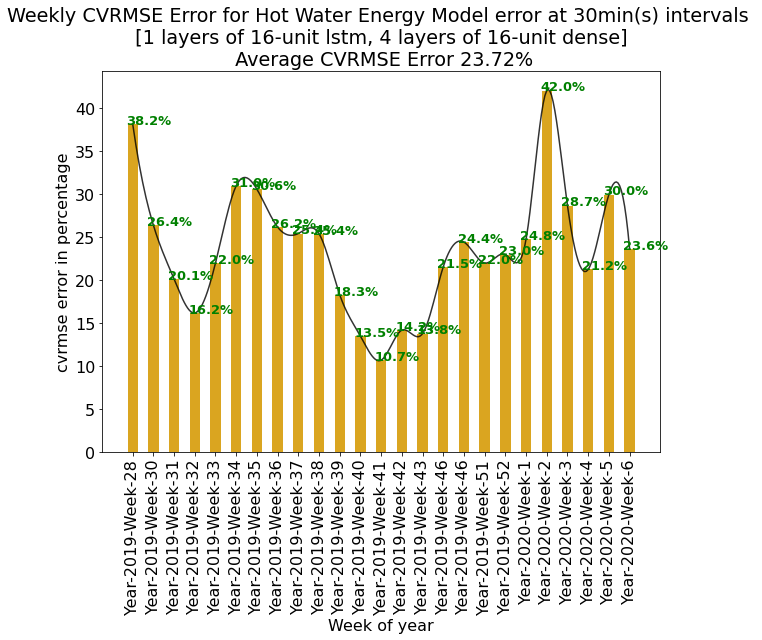

In [20]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape